# Prostate Cancer readout June 2021

In [1]:
# create a feature to hold all PSA data for modeling

In [1]:
from calzone import Calzone
from featureio import FeatureIO

import pandas as pd
import numpy as np

from pineapple.contrib.components.data_factories.matrix_factory import MatrixFactory as mf

from lims_api import Client
import json
import io
from pineappleflow.core.gcloud.client import GcsClient

from collections import Counter, defaultdict

from pineappleflow.core import experiment_context
import datetime
experiment_context.reset_context(0, "x", "x", datetime.datetime(2021, 6, 8,0,0))

import seaborn as sns
from matplotlib import pyplot as plt

In [43]:
# BOCA samples
# data stored and dsids and feature already created by Adam see ingest_cea.ipynb
with FeatureIO() as ftio:
    boca_dsids = ftio.get_datasets_for_feature("multicancer_protein_june_2021_readout","3")
    boca_metas = Calzone.get_dataset_metadata_with_ids(boca_dsids)
    boca_types = [m.raw_sample_metadata['lims_top_diagnosis']['cancer_type'] for m in boca_metas]

print(Counter(boca_types))

boca_dsids_healthy = []
boca_dsids_prostate_cancer = []
boca_dsids_breast_cancer = []
boca_dsids_ovarian_cancer = []
for dsid,ctype in zip(boca_dsids,boca_types):
    if ctype == 'Normal / Healthy NOS':
        boca_dsids_healthy.append(dsid) # existing training class: boca_samples_healthy_plasma
    elif ctype == 'Prostate Cancer':
        boca_dsids_prostate_cancer.append(dsid)
    elif ctype == 'Breast Cancer':
        boca_dsids_breast_cancer.append(dsid)
    elif ctype == 'Ovarian Cancer':
        boca_dsids_ovarian_cancer.append(dsid)

Missed Redis cache for ttl_key TS-212533391, reading from BigQuery instead


Counter({'Ovarian Cancer': 40, 'Normal / Healthy NOS': 38, 'Prostate Cancer': 30, 'Breast Cancer': 25})


In [12]:
# create new training class
ftio.create_training_class(training_class_name='boca_samples_prostate_cancer_plasma', 
                               desc='Centipede C prostate cancer plasma samples sent for clinical protein measures at BOCA',
                               datasets=boca_dsids_prostate_cancer)

# repeat for breast and ovarian if necessary

!ftio get tclasses | grep boca

boca_samples_healthy_plasma                                                	Healthy Centipede C plasma samples sent for clinical protein measures at ..	38          
boca_samples_cancer_plasma                                                 	Ovarian, prostate, and breast cancer Centipede C plasma samples sent for ..	95          
boca_samples_prostate_cancer_plasma                                        	Centipede C prostate cancer plasma samples sent for clinical protein meas..	30          


In [2]:
# filter healthy negs for male only samples
# boca_samples_healthy_plasma
# colorectal_plasma_healthy_polyp_n (64) -
#colorectal_plasma_healthy_polyp_y (31)
#Neg_noM4_centipedeC_cpg_dense_v3 (111)
#M4_negs_cpg_dense_no96plasmas_v1 (88)

def filter_males(tc):
    with FeatureIO() as ftio:
        dsids = ftio.get_datasets_for_training_class(tc)
        metas = Calzone.get_dataset_metadata_with_ids(dsids)
        #print(metas[0])
        sexes = [m.raw_sample_metadata["lims_patient"]["sex"] for m in metas]
        keep = [s=="Male" for s in sexes]
    return np.array(dsids)[keep]

#filter_males("boca_samples_healthy_plasma")

In [33]:
new_dsids = filter_males("boca_samples_healthy_plasma")
# FeatureIO().create_training_class(training_class_name='boca_samples_healthy_plasma_males', 
#                                desc='boca_samples_healthy_plasma filtered for males only',
#                                datasets=new_dsids)
print(len(FeatureIO().get_datasets_for_training_class("boca_samples_healthy_plasma")))
print(len(FeatureIO().get_datasets_for_training_class("boca_samples_healthy_plasma_males")))

38
23


In [29]:
new_dsids = filter_males("Neg_noM4_centipedeC_cpg_dense_v3")
# FeatureIO().create_training_class(training_class_name='Neg_noM4_centipedeC_cpg_dense_v3_males', 
#                                desc='Neg_noM4_centipedeC_cpg_dense_v3 filtered for males only',
#                                datasets=new_dsids)
print(len(FeatureIO().get_datasets_for_training_class("Neg_noM4_centipedeC_cpg_dense_v3")))
print(len(FeatureIO().get_datasets_for_training_class("Neg_noM4_centipedeC_cpg_dense_v3_males")))

111
54


In [30]:
new_dsids = filter_males("M4_negs_cpg_dense_no96plasmas_v1")
FeatureIO().create_training_class(training_class_name='M4_negs_cpg_dense_no96plasmas_v1_males', 
                               desc='M4_negs_cpg_dense_no96plasmas_v1 filtered for males only',
                               datasets=new_dsids)
print(len(FeatureIO().get_datasets_for_training_class("M4_negs_cpg_dense_no96plasmas_v1")))
print(len(FeatureIO().get_datasets_for_training_class("M4_negs_cpg_dense_no96plasmas_v1_males")))

88
15


In [45]:
new_dsids = filter_males("Neg_noM4_noBoca_centipedeC_cpg_dense_v3")
FeatureIO().create_training_class(training_class_name='Neg_noM4_noBoca_centipedeC_cpg_dense_v3_males', 
                               desc='Neg_noM4_noBoca_centipedeC_cpg_dense_v3 filtered for males only',
                               datasets=new_dsids)
print(len(FeatureIO().get_datasets_for_training_class("Neg_noM4_noBoca_centipedeC_cpg_dense_v3")))
print(len(FeatureIO().get_datasets_for_training_class("Neg_noM4_noBoca_centipedeC_cpg_dense_v3_males")))

Missed Redis cache for ttl_key TS-212535917, reading from BigQuery instead


73
31


In [31]:
new_dsids = filter_males("colorectal_plasma_healthy_polyp_n")
FeatureIO().create_training_class(training_class_name='colorectal_plasma_healthy_polyp_n_males', 
                               desc='colorectal_plasma_healthy_polyp_n filtered for males only',
                               datasets=new_dsids)
print(len(FeatureIO().get_datasets_for_training_class("colorectal_plasma_healthy_polyp_n")))
print(len(FeatureIO().get_datasets_for_training_class("colorectal_plasma_healthy_polyp_n_males")))

64
37


In [32]:
new_dsids = filter_males("colorectal_plasma_healthy_polyp_y")
FeatureIO().create_training_class(training_class_name='colorectal_plasma_healthy_polyp_y_males', 
                               desc='colorectal_plasma_healthy_polyp_y filtered for males only',
                               datasets=new_dsids)
print(len(FeatureIO().get_datasets_for_training_class("colorectal_plasma_healthy_polyp_y")))
print(len(FeatureIO().get_datasets_for_training_class("colorectal_plasma_healthy_polyp_y_males")))

Missed Redis cache for ttl_key TS-212531261, reading from BigQuery instead


31
14


In [15]:
# create a new feature for the PSA data
ftio.create_feature(
    name="PSA_proteins_june_2021_readout",
    version=1,
    author='BillieGould',
    desc="a feature to store all free psa and total psa data available for the june2021 prostate readout",
    shape=(2,),
    numpy_dtype=np.dtype('O'),
    allowed_assays=["targeted-panel"],
    column_metadata=[[{"name":"Free PSA ng/m"}, {"name":"Total PSA ng/mL"}]], #column_metadata Tuple[List[dict], ...]
    is_production=False
)

1940

In [30]:
ftio.update_column_metadata("PSA_proteins_june_2021_readout",1,
                           column_metadata=([{"name":"Free PSA ng/m"}, {"name":"Total PSA ng/mL"}],)
                           )

True

In [38]:
# test the new feature
mat = mf.create_from_training_classes(["boca_samples_prostate_cancer_plasma"],
                                            'PSA_proteins_june_2021_readout/v1',
                                            [1]
                                          )

Missed Redis cache for 29 datasets with timestamp 2021-06-08 00:00:00, reading from BigQuery instead


In [ ]:
#load the available PSA data
# this raw data already stored in GCS bucket "boca-proteomics-data-upload"
mat_psa = mf.create_from_training_classes(["boca_samples_healthy_plasma", "boca_samples_cancer_plasma"],
                                            'multicancer_protein_june_2021_readout/v3',
                                            [0,1])
print(mat_psa.shape)
print(mat_psa.column_metadata)

In [23]:
def standardize_psa(psa_val):
    if "H" in psa_val:
        return float(psa_val[:-2])
    else:
        return float(psa_val)
    
res = standardize_psa('7.15')
print(res)
res = standardize_psa('7.15 H')
print(res)

7.15
7.15


In [27]:
df_mat_psa = pd.DataFrame(mat_psa.x, columns=[d["name"] for d in mat_psa.column_metadata])

df_mat_psa["std PSA"] = df_mat_psa["Total PSA ng/mL"].apply(lambda x: standardize_psa(x))

df_mat_psa.head()

,CA 125 U/mL,CA 125 qual,CA 15-3 U/mL,CA 15-3 qual,CA 19-9 U/mL,CA 19-9 qual,CEA ng/mL,CEA qual,Free PSA ng/mL,Free PSA qual,Total PSA ng/mL,Total PSA qual,std PSA
0,8.48,NaN,7.48,NaN,21.16,NaN,1.76,NaN,0.82,NaN,7.65,H,7.65
1,9.84,NaN,13.95,NaN,10.65,NaN,2.07,NaN,1.24,H,7.15 H,H,7.15
2,11.76,NaN,4.36,NaN,3.12,NaN,1.17,NaN,0.903,NaN,5.91,H,5.91
3,10.63,NaN,7.1,NaN,6.42,NaN,0.907,NaN,2.4,H,11.27,H,11.27
4,9.16,NaN,17.21,NaN,9.2,NaN,1.09,NaN,0.616,NaN,4.89,H,4.89


In [29]:
# create feature vectors under the new feature

for dsid, (i, row) in zip(mat_psa.dataset_ids,df_mat_psa.iterrows()):
    print(row.values[[8,12]])
    ftio.create_feature_vector(
        "PSA_proteins_june_2021_readout",
        1,
        dsid,
        row.values[[8,12]],
        True
        )

len(ftio.get_datasets_for_feature("PSA_proteins_june_2021_readout", 1))

[0.82 7.65]
[1.24 7.15]
[0.903 5.91]
[2.4 11.27]
[0.616 4.89]
[1.06 8.27]
[0.8740000000000001 4.78]
[1.04 3.97]
[0.8540000000000001 6.85]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[1.08 19.83]
[0.01 0.007]
[0.01 0.007]
[1.8 17.76]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[0.015 0.205]
[0.358 5.59]
[1.1 4.61]
[0.11699999999999999 2.43]
[0.664 3.71]
[0.17300000000000001 2.32]
[0.8959999999999999 11.13]
[0.805 5.07]
[0.8909999999999999 6.59]
[0.67 3.61]
[0.01 0.007]
[1.24 8.84]
[1.31 9.85]
[0.604 2.48]
[0.34600000000000003 3.42]
[0.287 3.88]
[0.01 0.027]
[0.525 4.82]
[0.01 0.065]
[2.54 8.31]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[2.89 17.92]
[0.01 0.007]
[1.93 8.45]
[0.754 4.87]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[0.012 0.007]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[0.01 0.007]
[0.01 

133

In [3]:
# Gleason scores
mat = mf.create_from_training_classes(["boca_samples_prostate_cancer_plasma"],
                                            'PSA_proteins_june_2021_readout/v1',
                                            [1]
                                          )

sid_to_sec_id = dict(zip(mat.sample_ids, [m.raw_sample_metadata["lims_sample"]["secondary_id"] for m in mat.sample_metadata]))

In [4]:


df_gleason = pd.read_csv("./centipedeC_prostate_gleason_scores - centipede_C_prostate_gleason_scores.csv",header=0)
df_gleason.head()

,case no,gleason score1,gleason score2,gleason score total
0,1A1820,3,4,7
1,1A2081,4,3,7
2,1A2500,4,3,7
3,1A2518,4,4,8
4,1D1024,4,3,7


In [5]:
sec_id_to_gleason = {}
for i,row in df_gleason.iterrows():
    sec_id_to_gleason[row["case no"]] = (row["gleason score1"], row["gleason score2"], row["gleason score total"])
    

In [6]:
from pineapple.contrib.loaders.experiment_table_loader import ExperimentTableLoader

In [7]:
# methyl model scores

bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Prostate/June2021_readout/cancer-neg_single_mint_all-male_3CV_aux/"

loader_cross_val = ExperimentTableLoader(bucket,path)
df_samples = loader_cross_val.sample_score_per_fold_table()
df_samples['score_mean'] = df_samples.groupby(['sample_id'])['y_score'].transform(lambda x: np.mean(x))
df_samples = df_samples[['sample_id', 'y_true','score_mean']].drop_duplicates()
print(df_samples.head())
df_cancers = df_samples[df_samples["y_true"]==1]

EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.


   sample_id  y_true  score_mean
0     103793       1    0.996522
1     103818       1    0.822197
2     103850       1    0.527521
3     104787       1    0.411984
4     104813       1    0.356396


In [9]:
# how many samples do we have gleason scores for?
sec_ids = [sid_to_sec_id[sid] for sid in df_cancers["sample_id"]]
print(len([sec_id for sec_id in sec_ids if sec_id in sec_id_to_gleason.keys()]))

30


Text(0, 0.5, 'mean methyl score')

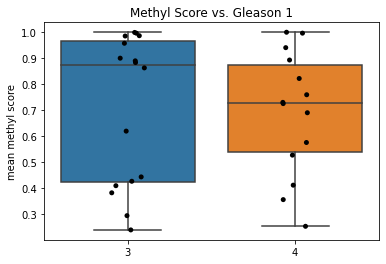

In [13]:

methyl_scores = df_cancers["score_mean"]

plt.figure()
plt.title("Methyl Score vs. Gleason 1")
sns.boxplot(x=[sec_id_to_gleason[sec_id][0] for sec_id in sec_ids],
              y=methyl_scores)
sns.stripplot(x=[sec_id_to_gleason[sec_id][0] for sec_id in sec_ids],
              y=methyl_scores, color="black")
plt.ylabel("mean methyl score")

Text(0, 0.5, 'mean methyl score')

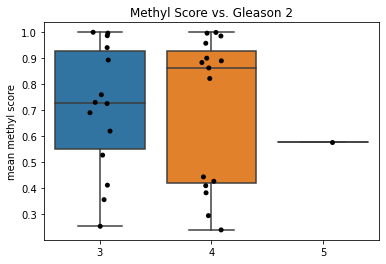

In [14]:
plt.figure()
plt.title("Methyl Score vs. Gleason 2")
sns.boxplot(x=[sec_id_to_gleason[sec_id][1] for sec_id in sec_ids],
              y=methyl_scores)
sns.stripplot(x=[sec_id_to_gleason[sec_id][1] for sec_id in sec_ids],
              y=methyl_scores, color="black")
plt.ylabel("mean methyl score")

Text(0, 0.5, 'mean methyl score')

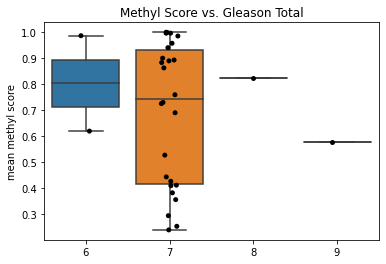

In [15]:
plt.figure()
plt.title("Methyl Score vs. Gleason Total")
sns.boxplot(x=[sec_id_to_gleason[sec_id][2] for sec_id in sec_ids],
              y=methyl_scores)
sns.stripplot(x=[sec_id_to_gleason[sec_id][2] for sec_id in sec_ids],
              y=methyl_scores, color="black")
plt.ylabel("mean methyl score")

## benchmarking PSA data from 2020

In [2]:
df = pd.read_csv("./20210324_boca_b1b2.csv")
df.head()

,sample_id,Secondary ID (Sample),Cancer Type (Diagnosis),Pathologic Type (Diagnosis),assay,in-house,clinical,ca153_125_outlier
0,22155,121230-pre,Colorectal Normal / Healthy,Negative by colonoscopy (no histopathology),Total PSA (ng/mL),0.517,1.310,False
1,23078,112503-post,Colorectal Cancer,Adenocarcinoma,Total PSA (ng/mL),0.001,0.007,False
2,20875,115286-pre,Colorectal Normal / Healthy,Negative by colonoscopy (no histopathology),Total PSA (ng/mL),0.256,0.742,False
3,21091,121503-post,Colorectal Cancer,Adenocarcinoma,Total PSA (ng/mL),0.920,1.920,False
4,20715,102431-pre,Colorectal Normal / Healthy,Negative by histopathology,Total PSA (ng/mL),0.796,1.470,False


In [3]:
df_healthy = df[df["Cancer Type (Diagnosis)"]=="Colorectal Normal / Healthy"]
df_healthy.shape

(285, 8)

In [4]:
from collections import Counter
Counter(df["Cancer Type (Diagnosis)"])

Counter({'Colorectal Normal / Healthy': 285,
         'Colorectal Cancer': 100,
         'Colorectal Benign': 100,
         'Colorectal Pre-Cancer': 15})

In [17]:
metas = Calzone.get_sample_metadata_with_ids(df_healthy["sample_id"])
ages = [m.raw_sample_metadata['lims_patient']['age'] for m in metas]
sexes = [m.raw_sample_metadata['lims_patient']['sex'] for m in metas]

Missed Redis cache for ttl_key TS-212533628, reading from BigQuery instead


In [18]:
Counter(sexes)

Counter({'Male': 170, 'Female': 115})

Text(0.5, 1.0, 'Healthy male patients, 2020 cohort (n=170)')

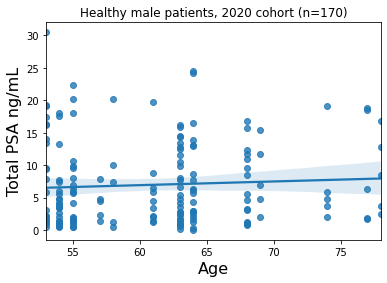

In [23]:
filter = [s=='Male' for s in sexes]
sns.regplot(x=np.array(ages)[filter], y=df_healthy[filter]["clinical"])
plt.xlabel("Age", size=16)
plt.ylabel("Total PSA ng/mL", size=16)
plt.title("Healthy male patients, 2020 cohort (n=170)")

In [16]:
metas[0]

CalzoneSampleMetadata(raw_sample_metadata={'lims_sample': {'secondary_id': '121230-pre', 'id': 22155, 'study_type': 'Prospective Clinical Study', 'collection_date': datetime.date(2019, 1, 15), 'collection_time': '14:20:00', 'collection_time_end': '14:23:00', 'age_at_blood_draw': 59, 'blood_draw_relative_to_tx': 'Pre-Colonoscopy', 'notes': None, 'sample_use': 'Standard', 'accession_date': '2019-01-16T01:31:58.917106+00:00', 'validated_by': 'mitch.bailey@freenome.com', 'validated_on': datetime.datetime(2019, 9, 24, 0, 0, tzinfo=<UTC>), 'double_checked_by': None, 'double_checked_on': None, 'phlebotomist_initials': 'DS', 'timing_confidence_level': 'Definite', 'protocol_version': '4.0.0', 'num_tubes_in_freezer': 8, 'num_tubes_known_location': 8, 'num_plasma_tubes_known_location': 8, 'total_volume_remaining_ml': 4.98, 'total_plasma_volume_remaining_ml': 4.98, 'num_tubes_with_process': 29}, 'lims_patient': {'id': 25203, 'secondary_id': '121230', 'sex': 'Male', 'ethnicity_northern_european': F